In [31]:
%matplotlib inline
%pylab inline
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import palettable as pal

Populating the interactive namespace from numpy and matplotlib


In [32]:
# transrate score metrics
file_ncgr_transrate_scores = "../assembly_evaluation_data/transrate_scores_imicrobe_cds.csv"
file_dib_transrate_scores = "../assembly_evaluation_data/transrate_scores_trinity-2.2.0.csv"
ncgr_transrate_score = pd.read_csv(file_ncgr_transrate_scores, index_col='SampleName')
dib_transrate_score = pd.read_csv(file_dib_transrate_scores, index_col='SampleName')
#transrate reference metrics
file_ncgr_transrate_nt = "../assembly_evaluation_data/transrate_reverse_ncgr.nt_v_trinity2.2.0.csv"
file_dib_transrate_nt = "../assembly_evaluation_data/transrate_reference_trinity2.2.0_v_ncgr.nt.csv"
ncgr_transrate_nt = pd.read_csv(file_ncgr_transrate_nt, index_col='SampleName')
dib_transrate_nt = pd.read_csv(file_dib_transrate_nt, index_col='SampleName')
# dammit gene names comparison
unique_names = pd.read_csv("../assembly_evaluation_data/unqiue_gene_names_ncgr_dib.csv")

In [33]:
giant_matrix = "~/Documents/UCDavis/dib/MMETSP/git/MMETSP/assembly_evaluation_data/MMETSP_all_evaluation_matrix.csv"
all_metrics = pd.read_csv(giant_matrix,index_col='SampleName')

In [34]:
dib_transrate_nt = dib_transrate_nt.drop_duplicates()
ncgr_transrate_nt = ncgr_transrate_nt.drop_duplicates()
# dammit gene names comparison
gene_names = unique_names.drop_duplicates()
# giant matrix of all metrics, including phyla
all_metrics = all_metrics.drop_duplicates()

In [35]:
#checking the comparison of the two sets. 
ddd=set(dib_transrate_nt.index) #special flowers are missing
ncnc=set(ncgr_transrate_nt.index)
len(ddd.intersection(ncnc))

651

In [36]:
def scatter_diff(df1, df2, column, fig, ax, df1name = 'df1', df2name = 'df2', 
                 color1='gray', color2='#018E42', ymin=0, ymax=1, ypos=.95):
    # plot scatter differences between two dfs with the same columns
    # create new df for data comparison
    
    combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
    newdf=pd.DataFrame(index=combined_df.index)
    newdf[df1name]=combined_df[column+'_x']
    newdf[df2name]=combined_df[column+'_y']

    # plot with different colors if df1 > or < then df2
    
    newdf.loc[newdf[df1name] > newdf[df2name], [df1name, df2name]].T.plot(ax=ax, legend = False, 
                                                                          color = color1, lw=2)
    newdf.loc[newdf[df1name] <= newdf[df2name], [df1name, df2name]].T.plot(ax=ax, legend = False, 
                                                                           color = color2, alpha = 0.5, lw=2)
    # prints numbers higher in DIB or NCGR assemblies
    #ax.text(-.1, ypos, str(len(newdf.loc[newdf[df1name] > newdf[df2name]])), 
            #color= color1, fontsize='x-large', fontweight='heavy')
    #ax.text(.95, ypos, str(len(newdf.loc[newdf[df1name] <= newdf[df2name]])), 
            #color= color2, fontsize='x-large', fontweight='heavy')

    # aesthetics 
    ax.set_xlim(-.15, 1.3)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([0,1])
    ax.set_xticklabels([df1name, df2name], fontsize='large', fontweight='bold')
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize='x-large')
    return newdf, fig, ax
    

def violin_split(df, col1, col2, fig, ax, color2='gray', color1='#018E42', ymin=0, ymax=1):
    #create split violine plots
    v1 = ax.violinplot(df[col1],
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v1['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        b.set_color(color2)
        b.set_alpha(0.85)
    v2 = ax.violinplot(df[col2],
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v2['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_color(color1)
        b.set_alpha(0.85)
    
    [x1,x2]=ax.get_xlim()
    #plot NCGR mean
    ax.plot([0,1], [df[col1].mean()]*2,'--', color='black')
    #plot DIB mean
    ax.plot([1,2], [df[col2].mean()]*2, '--', color='#004F24')
    ax.text(0.5+x1/2, df[col1].mean(), str(round(df[col1].mean(),2)), fontsize='x-large', fontweight='bold',multialignment='center')
    ax.text(0.5+x2/2, df[col2].mean(), str(round(df[col2].mean(),2)), fontsize='x-large', fontweight='bold',multialignment='center')

    ax.set_xlim(x1,x2)
    ax.set_xticks([])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis= 'both',labelsize='x-large')
    ax.set_axis_bgcolor('white')
    
def create_plots(df1, df2, column, col_title, df1name = 'NCGR', df2name = 'DIB', ymax = 1, ymin = 0, ypos = 0.90):
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(6,6)
    outdf, fig, ax = scatter_diff(df1, df2, column = column, 
                 fig = fig, ax = axs[0], df1name = df1name, df2name = df2name, 
                                  ymax = ymax, ymin = ymin, ypos = ypos)
    violin_split(outdf, df1name, df2name, fig, axs[1], ymin = ymin, ymax = ymax)
    fig.suptitle(col_title, fontsize = 'x-large', fontweight = 'bold')
    return outdf, fig, ax

/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:66: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


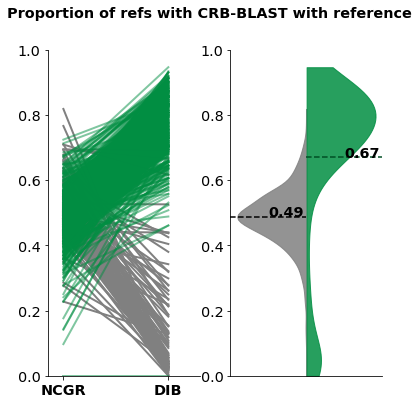

In [40]:
p_refs,fig, ax = create_plots(ncgr_transrate_nt,dib_transrate_nt, 'p_refs_with_CRBB', 'Proportion of refs with CRB-BLAST with reference',ymax=1, ypos=1)

fig.savefig('../paper/CRB-blast.pdf',bbox_inches="tight")
fig.savefig('../paper/CRB-blast.png',bbox_inches="tight")

/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:66: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


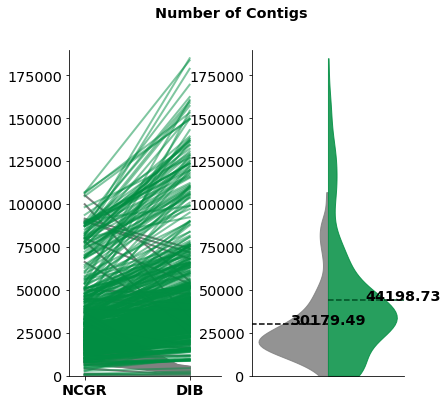

In [53]:
p_refs,fig, ax = create_plots(ncgr_transrate_nt,dib_transrate_nt, 'n_seqs', 'Number of Contigs',ymax=190000, ypos=55000)

fig.savefig('../paper/n_contigs.pdf',bbox_inches="tight")
fig.savefig('../paper/n_contigs.png',bbox_inches="tight")

/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:66: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


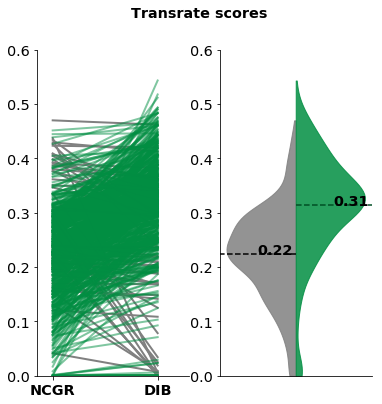

In [54]:
score,fig, ax = create_plots(ncgr_transrate_score,dib_transrate_score, 'score', 'Transrate scores',ymax=.6, ypos=0.55)
savefig('../paper/transrate.png',bbox_inches="tight")
savefig('../paper/transrate.pdf',bbox_inches="tight")

In [9]:
ncgr_transrate_nt.columns

Index(['assembly', 'n_seqs', 'smallest', 'largest', 'n_bases', 'mean_len',
       'n_under_200', 'n_over_1k', 'n_over_10k', 'n_with_orf',
       'mean_orf_percent', 'n90', 'n70', 'n50', 'n30', 'n10', 'gc', 'gc_skew',
       'at_skew', 'cpg_ratio', 'bases_n', 'proportion_n',
       'linguistic_complexity', 'CRBB_hits', 'n_contigs_with_CRBB',
       'p_contigs_with_CRBB', 'rbh_per_reference', 'n_refs_with_CRBB',
       'p_refs_with_CRBB', 'cov25', 'p_cov25', 'cov50', 'p_cov50', 'cov75',
       'p_cov75', 'cov85', 'p_cov85', 'cov95', 'p_cov95', 'reference_coverage',
       'score', 'optimal_score', 'cutoff', 'Run'],
      dtype='object')

/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:66: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


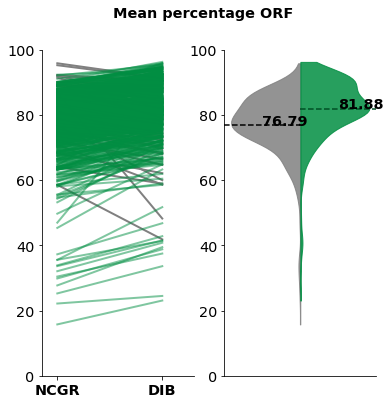

In [41]:
p_refs,fig, ax = create_plots(ncgr_transrate_nt,dib_transrate_nt, 'mean_orf_percent', 'Mean percentage ORF',ymax=100, ypos=100)
savefig('../paper/mean_ORF.pdf',bbox_inches="tight")
savefig('../paper/mean_ORF.png',bbox_inches="tight")

In [ ]:
p_refs,fig, ax = create_plots(ncgr_transrate_nt,dib_transrate_nt, 'mean_orf_percent', 'Mean percentage ORF',ymax=100, ypos=100)
savefig('../paper/mean_ORF.pdf',bbox_inches="tight")
savefig('../paper/mean_ORF.png',bbox_inches="tight")

In [42]:
imicrobe_busco = pd.read_csv("../assembly_evaluation_data/busco_scores_imicrobe_eukaryota.csv")

In [43]:
dib_busco = pd.read_csv("../assembly_evaluation_data/busco_scores_MMETSP_eukaryota_trinity2.2.0.csv")

/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/cohenl06/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:66: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


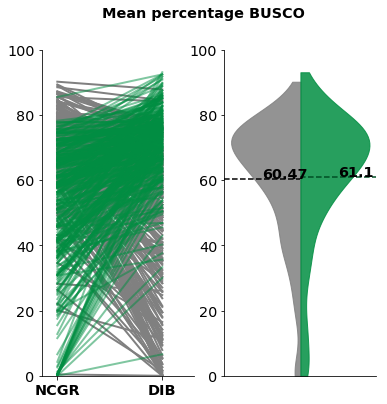

In [45]:
p_refs,fig, ax = create_plots(imicrobe_busco,dib_busco, 'Complete_BUSCO_perc', 'Mean percentage BUSCO',ymax=100, ypos=100)
savefig('../paper/mean_BUSCO.png',bbox_inches="tight")
savefig('../paper/mean_BUSCO.pdf',bbox_inches="tight")

In [21]:
df1=ncgr_transrate_nt
df2=dib_transrate_nt
column='p_refs_with_CRBB'
df1name = 'df1'
df2name = 'df2'
combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
newdf=pd.DataFrame(index=combined_df.index)
newdf[df1name]=combined_df[column+'_x']
newdf[df2name]=combined_df[column+'_y']
print('NCGR:',len(newdf.loc[newdf[df1name] > newdf[df2name]]))
print('DIB:',len(newdf.loc[newdf[df1name] <= newdf[df2name]]))

('NCGR:', 106)
('DIB:', 545)


In [23]:
df1=ncgr_transrate_nt
df2=dib_transrate_nt
column='n_seqs'
df1name = 'df1'
df2name = 'df2'
combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
newdf=pd.DataFrame(index=combined_df.index)
newdf[df1name]=combined_df[column+'_x']
newdf[df2name]=combined_df[column+'_y']
print('NCGR:',len(newdf.loc[newdf[df1name] > newdf[df2name]]))
print('DIB:',len(newdf.loc[newdf[df1name] <= newdf[df2name]]))

('NCGR:', 107)
('DIB:', 544)


In [27]:
df1=ncgr_transrate_nt
df2=dib_transrate_nt
column='mean_orf_percent'
df1name = 'df1'
df2name = 'df2'
combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
newdf=pd.DataFrame(index=combined_df.index)
newdf[df1name]=combined_df[column+'_x']
newdf[df2name]=combined_df[column+'_y']
print('NCGR:',len(newdf.loc[newdf[df1name] > newdf[df2name]]))
print('DIB:',len(newdf.loc[newdf[df1name] <= newdf[df2name]]))

('NCGR:', 45)
('DIB:', 606)


In [26]:
df1.head()

,assembly,n_seqs,smallest,largest,n_bases,mean_len,n_under_200,n_over_1k,n_over_10k,n_with_orf,...,p_cov75,cov85,p_cov85,cov95,p_cov95,reference_coverage,score,optimal_score,cutoff,Run
SampleName,,,,,,,,,,,,,,,,,,,,,
MMETSP0271,/mnt/research/ged/lisa/mmetsp/imicrobe/nt/MMET...,106264,150,18933,117126237,1083.72243,11390,45658,103,69333,...,0.19241,24850,0.16221,12950,0.08453,0.35226,NaN,NaN,NaN,MMETSP0271
MMETSP1366,/mnt/research/ged/lisa/mmetsp/imicrobe/nt/MMET...,36792,150,12093,30992217,814.70798,5940,11474,2,19862,...,0.20916,8765,0.16782,3887,0.07442,0.27545,NaN,NaN,NaN,MMETSP1366
MMETSP1103,/mnt/research/ged/lisa/mmetsp/imicrobe/nt/MMET...,19457,150,12410,25474774,1296.42643,1450,9579,15,12579,...,0.28158,6393,0.23677,2593,0.09603,0.36500,NaN,NaN,NaN,MMETSP1103
MMETSP0014,/mnt/research/ged/lisa/mmetsp/imicrobe/nt/MMET...,46582,150,16843,88191331,1882.39921,2972,32562,105,37292,...,0.14770,7422,0.11772,3343,0.05302,0.28402,NaN,NaN,NaN,MMETSP0014
MMETSP0916,/mnt/research/ged/lisa/mmetsp/imicrobe/nt/MMET...,21990,150,23792,15879726,697.43006,3143,4822,8,11111,...,0.19782,4625,0.14132,1602,0.04895,0.27051,NaN,NaN,NaN,MMETSP0916


In [30]:
df1=ncgr_transrate_score
df2=dib_transrate_score
column='score'
df1name = 'df1'
df2name = 'df2'
combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
newdf=pd.DataFrame(index=combined_df.index)
newdf[df1name]=combined_df[column+'_x']
newdf[df2name]=combined_df[column+'_y']
print('NCGR:',len(newdf.loc[newdf[df1name] > newdf[df2name]]))
print('DIB:',len(newdf.loc[newdf[df1name] <= newdf[df2name]]))

('NCGR:', 52)
('DIB:', 575)
